In [ ]:
import pandas as pd
import glob
import os

output_file = "CICIDS2018_combined.csv"
csv_files = glob.glob(r"C:\Users\izzat\Downloads\CICIDS2018\*.csv")

if os.path.exists(output_file):
    os.remove(output_file)

# Read and write in chunks to handle memory limits
for i, file in enumerate(csv_files):
    print(f"Processing: {file}")
    chunk_iter = pd.read_csv(file, chunksize=100000, low_memory=False)  # Read 100k rows at a time

    for j, chunk in enumerate(chunk_iter):
        if i == 0 and j == 0:
            chunk.to_csv(output_file, index=False, mode='w') 
        else:
            chunk.to_csv(output_file, index=False, mode='a', header=False) 

print(" Done combining files.")

Processing: C:\Users\izzat\Downloads\CICIDS2018\02-14-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-15-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-16-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-20-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-21-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-22-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-23-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\02-28-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\03-01-2018.csv
Processing: C:\Users\izzat\Downloads\CICIDS2018\03-02-2018.csv
 Done combining files.


In [ ]:
import pandas as pd

output_file = "CICIDS2018_combined.csv"
chunk_size = 100000

all_rows = [] 
max_chunks = 3 

reader = pd.read_csv(output_file, chunksize=chunk_size, low_memory=False, on_bad_lines='skip')

for i, chunk in enumerate(reader):
    print(f"Loaded chunk {i+1} with shape: {chunk.shape}")
    all_rows.append(chunk)
    if i + 1 == max_chunks:
        break

df = pd.concat(all_rows, ignore_index=True)
print("Combined partial DataFrame:")
print(df.shape)

Loaded chunk 1 with shape: (100000, 80)
Loaded chunk 2 with shape: (100000, 80)
Loaded chunk 3 with shape: (100000, 80)
Combined partial DataFrame:
(300000, 80)


In [3]:
df.to_csv("CICIDS2018_cleaned.csv", index=False)
print(" Saved cleaned CSV as 'CICIDS2018_cleaned.csv'")

 Saved cleaned CSV as 'CICIDS2018_cleaned.csv'


In [4]:
import pandas as pd
import os

input_file = "CICIDS2018_cleaned.csv"
output_file = "CICIDS2018_final_cleaned.csv"
chunksize = 50000

# Step 1: First pass – gather all columns that will remain after dropping "useless" ones
all_columns = set()

print(" Scanning column structure...")

for chunk in pd.read_csv(input_file, chunksize=chunksize, low_memory=False):
    chunk.dropna(axis=0, how='all', inplace=True)  # Drop empty rows
    chunk.dropna(axis=1, how='all', inplace=True)  # Drop empty columns

    # Drop columns with only 1 unique value
    nunique = chunk.nunique()
    cols_to_keep = nunique[nunique > 1].index
    chunk = chunk[cols_to_keep]
    
    all_columns.update(chunk.columns)

all_columns = sorted(list(all_columns))  # Keep order consistent
print(f" Found {len(all_columns)} columns after scanning.")

# Step 2: Second pass – clean and re-align all chunks to match the full column set
if os.path.exists(output_file):
    os.remove(output_file)  # Remove if already exists

print(" Cleaning and saving all chunks...")

for i, chunk in enumerate(pd.read_csv(input_file, chunksize=chunksize, low_memory=False)):
    chunk.dropna(axis=0, how='all', inplace=True)
    chunk.dropna(axis=1, how='all', inplace=True)

    nunique = chunk.nunique()
    cols_to_keep = nunique[nunique > 1].index
    chunk = chunk[cols_to_keep]

    # Re-align to all columns (missing columns will be filled with NaN)
    chunk = chunk.reindex(columns=all_columns)

    # Append to final file
    if i == 0:
        chunk.to_csv(output_file, index=False)
    else:
        chunk.to_csv(output_file, index=False, header=False, mode='a')

print(" All chunks cleaned and saved properly with aligned columns.")

 Scanning column structure...
 Found 67 columns after scanning.
 Cleaning and saving all chunks...
 All chunks cleaned and saved properly with aligned columns.


In [5]:
df = pd.read_csv("CICIDS2018_final_cleaned.csv", low_memory=False)

In [6]:
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
ACK Flag Cnt            0
Active Max         100000
Active Mean        100000
Active Min         100000
Active Std         250000
                    ...  
Tot Bwd Pkts            0
Tot Fwd Pkts            0
TotLen Bwd Pkts         0
TotLen Fwd Pkts         0
URG Flag Cnt       150000
Length: 67, dtype: int64


In [7]:
# Drop columns with too many missing values
df = df.loc[:, df.isnull().mean() < 0.7]

# Fill remaining NaNs
df.fillna(df.median(numeric_only=True), inplace=True)

In [8]:
print(df.isna().sum())  # Should all be zero now
print(f"Final shape: {df.shape}")  # Rows x Columns

ACK Flag Cnt       0
Active Max         0
Active Mean        0
Active Min         0
Bwd Header Len     0
                  ..
Tot Bwd Pkts       0
Tot Fwd Pkts       0
TotLen Bwd Pkts    0
TotLen Fwd Pkts    0
URG Flag Cnt       0
Length: 66, dtype: int64
Final shape: (300000, 66)


In [9]:
# Drop columns with >30% missing values
threshold = 0.3
df = df.loc[:, df.isnull().mean() < threshold]

In [10]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [11]:
print("Missing values after cleanup:")
print(df.isna().sum().sum())  # should be 0

print("Final shape after cleanup:", df.shape)

Missing values after cleanup:
0
Final shape after cleanup: (300000, 66)


In [12]:
missing_cols = df.columns[df.isna().any()].tolist()
print("Columns with missing values:", missing_cols)
print(df[missing_cols].isna().sum())

Columns with missing values: []
Series([], dtype: float64)


In [13]:
for col in missing_cols:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna("unknown")

In [14]:
print(" All missing values fixed?" , df.isna().sum().sum() == 0)
print(" Final shape:", df.shape)

 All missing values fixed? True
 Final shape: (300000, 66)


In [15]:
# Drop columns with >30% missing values
threshold = 0.3
df = df.loc[:, df.isnull().mean() < threshold]

In [16]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [17]:
print("Missing values after cleanup:")
print(df.isna().sum().sum())  # should be 0

print("Final shape after cleanup:", df.shape)

Missing values after cleanup:
0
Final shape after cleanup: (300000, 66)


In [18]:
print(df.dtypes.value_counts())

int64      35
float64    29
object      2
Name: count, dtype: int64


In [19]:
print(df.head())
print(df.info())

   ACK Flag Cnt  Active Max  Active Mean  Active Min  Bwd Header Len  \
0             0         0.0          0.0         0.0               0   
1             0         0.0          0.0         0.0               0   
2             0         0.0          0.0         0.0               0   
3             0         0.0          0.0         0.0             328   
4             0         0.0          0.0         0.0             360   

   Bwd IAT Max   Bwd IAT Mean  Bwd IAT Min    Bwd IAT Std  Bwd IAT Tot  ...  \
0            0       0.000000            0       0.000000            0  ...   
1            0       0.000000            0       0.000000            0  ...   
2            0       0.000000            0       0.000000            0  ...   
3      1167293  626433.555556          554  455082.214224      5637902  ...   
4      2174893  771548.100000           90  755543.082717      7715481  ...   

   Subflow Bwd Byts  Subflow Bwd Pkts  Subflow Fwd Byts  Subflow Fwd Pkts  \
0              

In [20]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [21]:
df = df.fillna(df.median(numeric_only=True))

In [22]:
print(df.dtypes.value_counts())

int64      35
float64    31
Name: count, dtype: int64


In [23]:
df = df.select_dtypes(include=['number'])  # keeps only numeric columns

In [ ]:
print(df.isna().sum().sum())  
print(df.dtypes.value_counts()) 
print(df.shape)                 

600000
int64      35
float64    31
Name: count, dtype: int64
(300000, 66)


In [25]:
# DONE WITH DATA EXTRACTION & CLEANING

In [ ]:
import os
import pandas as pd

folder_path = "C:/Users/izzat/Downloads/CICIDS2018"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

chunks = []
max_rows_per_file = 50000

for i, file in enumerate(all_files):
    print(f"Reading {file}...")
    try:
        chunk = pd.read_csv(file, nrows=max_rows_per_file, on_bad_lines='skip', low_memory=False)
        chunks.append(chunk)
        print(f"Loaded {len(chunk)} rows.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

df = pd.concat(chunks, ignore_index=True)
print(f"\n Combined partial dataset shape: {df.shape}")

Reading C:/Users/izzat/Downloads/CICIDS2018\02-14-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-15-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-16-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-20-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-21-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-22-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-23-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\02-28-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\03-01-2018.csv...
Loaded 50000 rows.
Reading C:/Users/izzat/Downloads/CICIDS2018\03-02-2018.csv...
Loaded 50000 rows.

 Combined partial dataset shape: (500000, 84)


In [28]:
print(df.columns.tolist())

['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd By

In [29]:
# Show unique values in the Label column
print(df["Label"].unique())

# Show how many samples there are for each label
print(df["Label"].value_counts())

['Benign' 'FTP-BruteForce' 'DoS attacks-GoldenEye' 'DoS attacks-Slowloris'
 'DoS attacks-SlowHTTPTest' 'DDoS attacks-LOIC-HTTP'
 'DDOS attack-LOIC-UDP' 'DDOS attack-HOIC' 'Brute Force -Web'
 'Brute Force -XSS' 'SQL Injection' 'Label' 'Bot']
Label
Benign                      212756
DDoS attacks-LOIC-HTTP       49927
FTP-BruteForce               49895
DoS attacks-SlowHTTPTest     49881
DDOS attack-HOIC             46067
Bot                          40455
DoS attacks-GoldenEye        38790
DoS attacks-Slowloris         9565
DDOS attack-LOIC-UDP          1730
Brute Force -Web               611
Brute Force -XSS               230
SQL Injection                   87
Label                            6
Name: count, dtype: int64


In [30]:
# Drop rows where Label == "Label"
df = df[df["Label"] != "Label"]

In [31]:
df["Label"] = df["Label"].replace({
    # DDoS variants
    "DDOS attack-HOIC": "DDoS",
    "DDoS attacks-LOIC-HTTP": "DDoS",
    "DDOS attack-LOIC-UDP": "DDoS",
    "DoS attacks-Hulk": "DDoS",
    "DoS attacks-GoldenEye": "DDoS",
    "DoS attacks-Slowloris": "DDoS",
    "DoS attacks-SlowHTTPTest": "DDoS",

    # Brute Force variants
    "FTP-BruteForce": "Brute Force",
    "SSH-Bruteforce": "Brute Force",
    "Brute Force -Web": "Brute Force",
    "Brute Force -XSS": "Brute Force",

    # Keep SQL Injection and others as is
})

In [32]:
print(df["Label"].value_counts())

Label
Benign           212756
DDoS             195960
Brute Force       50736
Bot               40455
SQL Injection        87
Name: count, dtype: int64


In [33]:
df.drop(columns=["Flow ID", "Src IP", "Dst IP", "Timestamp"], inplace=True)

In [34]:
df["Label"] = df["Label"].astype("category")
df["Label_cat"] = df["Label"].cat.codes

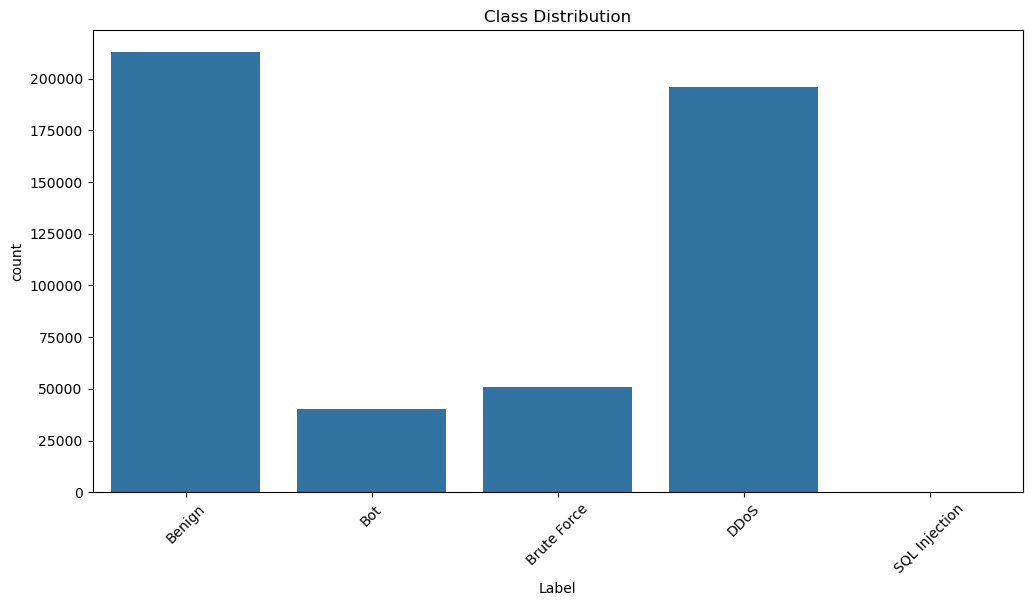

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Label")
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

In [36]:
print("Missing values per column:")
print(df.isnull().sum())

print("\nTotal missing values:")
print(df.isnull().sum().sum())

Missing values per column:
Dst Port              0
Protocol              0
Flow Duration         0
Tot Fwd Pkts          0
Tot Bwd Pkts          0
                  ...  
Idle Max              0
Idle Min              0
Label                 0
Src Port         449994
Label_cat             0
Length: 81, dtype: int64

Total missing values:
451178


In [37]:
print(df.dtypes.value_counts())

object      78
category     1
float64      1
int8         1
Name: count, dtype: int64


In [38]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 141732


In [39]:
print("Unique labels:", df["Label"].unique())
print("\nLabel distribution:\n", df["Label"].value_counts())

Unique labels: ['Benign', 'Brute Force', 'DDoS', 'SQL Injection', 'Bot']
Categories (5, object): ['Benign', 'Bot', 'Brute Force', 'DDoS', 'SQL Injection']

Label distribution:
 Label
Benign           212756
DDoS             195960
Brute Force       50736
Bot               40455
SQL Injection        87
Name: count, dtype: int64


In [40]:
df = df.drop_duplicates()

In [41]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [42]:
for col in df.columns:
    if df[col].dtype == "object" and col != "Label":
        print(f"{col}: {df[col].unique()[:5]}")  # Show first few unique values

Dst Port: [0 22 80 67 9984]
Protocol: [0 6 17 '6' '0']
Flow Duration: [112641719 112641466 112638623 6453966 8804066]
Tot Fwd Pkts: [3 15 14 16 5]
Tot Bwd Pkts: [0 10 11 12 3]
TotLen Fwd Pkts: [0 1239 1143 211 220]
TotLen Bwd Pkts: [0 2273 2209 463 472]
Fwd Pkt Len Max: [0 744 211 220 209]
Fwd Pkt Len Min: [0 300 64 8 230]
Fwd Pkt Len Mean: [0.0 82.6 81.6428571429 77.4375 42.2]
Fwd Pkt Len Std: [0.0 196.7412368715 203.7455453568 190.8311535538 94.3620686505]
Bwd Pkt Len Max: [0 976 463 472 461]
Bwd Pkt Len Min: [0 329 64 60 48]
Bwd Pkt Len Mean: [0.0 227.3 200.8181818182 189.4166666667 154.3333333333]
Bwd Pkt Len Std: [0.0 371.6778922072 362.2498635422 347.6425694023 267.3131746348]
Flow Byts/s: [0.0 544.1615279659 380.7331748762 502.4794183028 1414.4419984345]
Flow Pkts/s: [0.0266331163 0.0266331761 0.0266338483 3.8735871865 2.839597068]
Flow IAT Mean: [56320859.5 56320733.0 56319311.5 268915.25 366836.083333333]
Flow IAT Std: [139.3000358938 114.5512985522 301.9345955667 247443.77896

In [43]:
columns_to_drop = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Src Port']
df = df.drop(columns=columns_to_drop, errors='ignore')

In [44]:
# Convert all columns except 'Label' and 'Label_cat' to numeric
for col in df.columns:
    if col not in ['Label', 'Label_cat']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [45]:
#DATA TRANSFORMATION STEPS BELOW

In [46]:
X = df.drop(columns=['Label', 'Label_cat'])
y = df['Label_cat']  

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Ensure X is a DataFrame
X = pd.DataFrame(X)

# Step 2: Fix Flow Duration if negative
if 'Flow Duration' in X.columns:
    X['Flow Duration'] = X['Flow Duration'].abs()

# Step 3: List of columns with very large values to apply log transform
high_magnitude_cols = ['Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Flow Duration']

# Keep only those that exist in your DataFrame
cols_to_log = [col for col in high_magnitude_cols if col in X.columns]

# Apply signed log transform (log1p for numerical stability)
for col in cols_to_log:
    X[col] = np.log1p(np.abs(X[col])) * np.sign(X[col])

# Step 4: Replace inf/-inf with NaN and handle them
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Step 5: Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional sanity check
print("Any NaNs:", np.isnan(X_scaled).any())
print("Any Infs:", np.isinf(X_scaled).any())

Any NaNs: False
Any Infs: False


In [48]:
print("Max value:", np.max(X.values))
print("Min value:", np.min(X.values))

Max value: 708000000.0
Min value: -1.0


In [49]:
print(X.describe().T[['min', 'max']])

                    min           max
Dst Port       0.000000  6.553100e+04
Protocol       0.000000  1.700000e+01
Flow Duration  0.693147  1.860300e+01
Tot Fwd Pkts   1.000000  3.096290e+05
Tot Bwd Pkts   0.000000  3.841700e+04
...                 ...           ...
Active Min     0.000000  1.122069e+08
Idle Mean      0.000000  1.860300e+01
Idle Std       0.000000  1.813214e+01
Idle Max       0.000000  1.860300e+01
Idle Min       0.000000  1.860300e+01

[78 rows x 2 columns]


In [50]:
print(X.describe().T[['min', 'max']].sort_values(by='max', ascending=False).head(10))

              min          max
Flow Byts/s   0.0  708000000.0
Fwd IAT Min   0.0  120000000.0
Bwd IAT Min   0.0  120000000.0
Bwd IAT Max   0.0  120000000.0
Bwd IAT Mean  0.0  120000000.0
Bwd IAT Tot   0.0  120000000.0
Fwd IAT Max   0.0  120000000.0
Fwd IAT Mean  0.0  120000000.0
Fwd IAT Tot   0.0  120000000.0
Flow IAT Max  1.0  120000000.0


In [51]:
print((X.max().sort_values(ascending=False)).head(5))
print((X.min().sort_values()).head(5))

Flow Byts/s     708000000.0
Fwd IAT Min     120000000.0
Bwd IAT Min     120000000.0
Bwd IAT Max     120000000.0
Bwd IAT Mean    120000000.0
dtype: float64
Init Bwd Win Byts   -1.0
Init Fwd Win Byts   -1.0
Pkt Size Avg         0.0
Down/Up Ratio        0.0
ECE Flag Cnt         0.0
dtype: float64


In [52]:
for col in X.columns:
    X[col] = X[col].clip(lower=-1e6, upper=1e6)

In [53]:
extreme_cols = ['Fwd IAT Max', 'Flow IAT Max', 'Flow IAT Std', 'Fwd IAT Std', 
                'Flow Byts/s', 'Flow IAT Min', 'Fwd IAT Min', 'Fwd IAT Tot',
                'Flow IAT Mean']
X.drop(columns=extreme_cols, inplace=True)

In [54]:
import pandas as pd

# Load just 500 rows to inspect columns
sample = pd.read_csv("CICIDS2018_combined.csv", nrows=500, on_bad_lines='skip')
print(sample.columns.tolist())

['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd By

In [55]:
chunk_size = 50000
chunks = []

cols_to_use = [
    'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
    'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
    'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
    'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
    'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags',
    'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
    'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
    'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
    'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
    'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
    'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
    'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
    'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
    'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
    'Idle Min', 'Label'
]

df_chunks = pd.read_csv(
    "CICIDS2018_combined.csv",
    usecols=cols_to_use,
    chunksize=50000,
    on_bad_lines='skip',
    low_memory=False
)

In [56]:
import pandas as pd

chunk_size = 500_000

for i, chunk in enumerate(pd.read_csv(
    'CICIDS2018_combined.csv',
    chunksize=chunk_size,
    on_bad_lines='skip',  # skip bad rows
    engine='python'       # more tolerant of malformed data
)):
    print(f"Chunk {i} read successfully with {len(chunk)} rows")

Chunk 0 read successfully with 500000 rows
Chunk 1 read successfully with 500000 rows
Chunk 2 read successfully with 500000 rows
Chunk 3 read successfully with 500000 rows
Chunk 4 read successfully with 500000 rows
Chunk 5 read successfully with 500000 rows
Chunk 6 read successfully with 145725 rows
Chunk 7 read successfully with 0 rows
Chunk 8 read successfully with 0 rows
Chunk 9 read successfully with 0 rows
Chunk 10 read successfully with 0 rows
Chunk 11 read successfully with 0 rows
Chunk 12 read successfully with 0 rows
Chunk 13 read successfully with 0 rows
Chunk 14 read successfully with 0 rows
Chunk 15 read successfully with 0 rows
Chunk 16 read successfully with 0 rows
Chunk 17 read successfully with 0 rows
Chunk 18 read successfully with 0 rows
Chunk 19 read successfully with 0 rows
Chunk 20 read successfully with 0 rows
Chunk 21 read successfully with 0 rows
Chunk 22 read successfully with 405527 rows
Chunk 23 read successfully with 500000 rows
Chunk 24 read successfully wi

In [57]:
import pandas as pd

chunk_size = 500_000
first_chunk = True

with pd.read_csv(
    'CICIDS2018_combined.csv',
    chunksize=chunk_size,
    on_bad_lines='skip',
    engine='python'  # engine='python' is better for malformed lines
) as reader:
    for i, chunk in enumerate(reader):
        print(f"Chunk {i} read with {len(chunk)} rows")

        chunk.to_csv(
            'CICIDS2018_cleaned.csv',
            mode='w' if first_chunk else 'a',
            index=False,
            header=first_chunk
        )
        first_chunk = False

print(" All chunks saved to 'CICIDS2018_cleaned.csv'")

Chunk 0 read with 500000 rows
Chunk 1 read with 500000 rows
Chunk 2 read with 500000 rows
Chunk 3 read with 500000 rows
Chunk 4 read with 500000 rows
Chunk 5 read with 500000 rows
Chunk 6 read with 145725 rows
Chunk 7 read with 0 rows
Chunk 8 read with 0 rows
Chunk 9 read with 0 rows
Chunk 10 read with 0 rows
Chunk 11 read with 0 rows
Chunk 12 read with 0 rows
Chunk 13 read with 0 rows
Chunk 14 read with 0 rows
Chunk 15 read with 0 rows
Chunk 16 read with 0 rows
Chunk 17 read with 0 rows
Chunk 18 read with 0 rows
Chunk 19 read with 0 rows
Chunk 20 read with 0 rows
Chunk 21 read with 0 rows
Chunk 22 read with 405527 rows
Chunk 23 read with 500000 rows
Chunk 24 read with 500000 rows
Chunk 25 read with 500000 rows
Chunk 26 read with 500000 rows
Chunk 27 read with 500000 rows
Chunk 28 read with 500000 rows
Chunk 29 read with 500000 rows
Chunk 30 read with 500000 rows
Chunk 31 read with 500000 rows
Chunk 32 read with 233002 rows
 All chunks saved to 'CICIDS2018_cleaned.csv'


In [58]:
import pandas as pd

chunk_size = 100_000
output_file = 'CICIDS2018_cleaned_noNaNs.csv'
first_chunk = True

for i, chunk in enumerate(pd.read_csv(
    'CICIDS2018_combined.csv',
    chunksize=chunk_size,
    engine='python',            # safer but slower
    on_bad_lines='skip',        # skip problematic lines
    encoding='utf-8'
)):

    print(f"Reading Chunk {i}...")

    chunk.dropna(inplace=True)

    print(f"Cleaned Chunk {i}: {len(chunk)} rows")

    chunk.to_csv(output_file, mode='a', index=False, header=first_chunk)
    first_chunk = False

print("\n Final cleaned dataset saved to 'CICIDS2018_cleaned_noNaNs.csv'")

Reading Chunk 0...
Cleaned Chunk 0: 99997 rows
Reading Chunk 1...
Cleaned Chunk 1: 99998 rows
Reading Chunk 2...
Cleaned Chunk 2: 100000 rows
Reading Chunk 3...
Cleaned Chunk 3: 99925 rows
Reading Chunk 4...
Cleaned Chunk 4: 99680 rows
Reading Chunk 5...
Cleaned Chunk 5: 99693 rows
Reading Chunk 6...
Cleaned Chunk 6: 99612 rows
Reading Chunk 7...
Cleaned Chunk 7: 99743 rows
Reading Chunk 8...
Cleaned Chunk 8: 99572 rows
Reading Chunk 9...
Cleaned Chunk 9: 99655 rows
Reading Chunk 10...
Cleaned Chunk 10: 99848 rows
Reading Chunk 11...
Cleaned Chunk 11: 99536 rows
Reading Chunk 12...
Cleaned Chunk 12: 99469 rows
Reading Chunk 13...
Cleaned Chunk 13: 99518 rows
Reading Chunk 14...
Cleaned Chunk 14: 99483 rows
Reading Chunk 15...
Cleaned Chunk 15: 99543 rows
Reading Chunk 16...
Cleaned Chunk 16: 99532 rows
Reading Chunk 17...
Cleaned Chunk 17: 99478 rows
Reading Chunk 18...
Cleaned Chunk 18: 99511 rows
Reading Chunk 19...
Cleaned Chunk 19: 99552 rows
Reading Chunk 20...
Cleaned Chunk 20: 9